In [1]:
#import needed packages
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from datetime import datetime as dt
from statsmodels.graphics.gofplots import ProbPlot

import plotly.express as px

import sklearn
from sklearn.feature_selection import VarianceThreshold
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import cluster
from sklearn.cluster import KMeans, MiniBatchKMeans
from kneed import KneeLocator
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.vq import kmeans
from scipy.spatial.distance import cdist,pdist
from matplotlib import cm

# Libraries needed for hierarchical clustering.
from scipy import cluster
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [2]:
#set directory
home_dir = Path(".").resolve()
main_dir = home_dir.parent.parent
data_dir= str(main_dir)+'\Data'

os.chdir(data_dir)

In [3]:
lego_subset= pd.read_csv('LEGO_subset1.csv')
print(lego_subset.shape)
lego_subset.head()
lego_subset= lego_subset.drop(columns='Unnamed: 0')
lego_subset.head()

(10165, 8)


,list_price,piece_count,num_reviews,review_difficulty,star_rating,country_num,min_age
0,29.99,277.0,2.0,3,4.5,1,6.0
1,19.99,168.0,2.0,2,5.0,1,6.0
2,12.99,74.0,11.0,2,4.3,1,6.0
3,99.99,1032.0,23.0,3,4.6,1,12.0
4,79.99,744.0,14.0,4,4.6,1,12.0


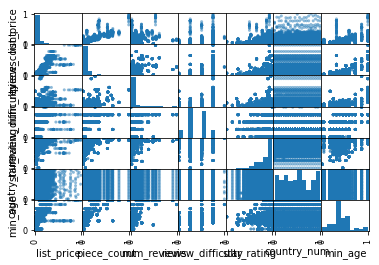

In [4]:
lego_cluster= lego_subset[['list_price', 'piece_count', 'num_reviews', 'review_difficulty', 'star_rating',
                               'country_num', 'min_age']]
 
#instantiate MinMaxScaler
scaler= MinMaxScaler()
lego_cluster_scaled= scaler.fit_transform(lego_subset)
lego_kmeans= pd.DataFrame(lego_cluster_scaled, columns = lego_cluster.columns)

lego_kmeans.head()
lego_kmeans.dtypes

scatter_m= scatter_matrix(lego_kmeans)
plt.show()

[[0.05780231 0.07199402 0.0439529  0.36349393 0.84488837 0.21268116
  0.41107824]
 [0.06768989 0.07660128 0.04651074 0.37097252 0.84540547 0.74828029
  0.41431113]]


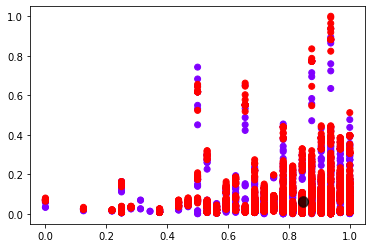

In [5]:
#intialize K means
lego_kmeans_default= KMeans(n_clusters=2)
#fit with inputs
lego_kmeans_default= lego_kmeans_default.fit(lego_kmeans)
#predict clusers
lego_labels= lego_kmeans_default.fit(lego_kmeans)
#get cluster centers
lego_C_default= lego_kmeans_default.cluster_centers_
print(lego_C_default)


#plot clusters first
plt.scatter(lego_kmeans.iloc[:,4], lego_kmeans.iloc[:,0],
            c=lego_kmeans_default.labels_,
            cmap='rainbow')

#plot centroids over clusters
plt.scatter(lego_C_default[:,4], lego_C_default[:,0],
            c='black', s=100, alpha=0.5)

3


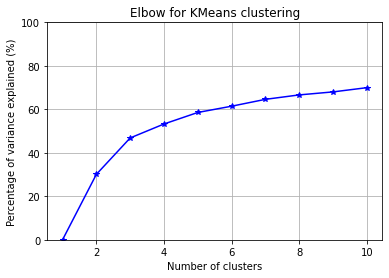

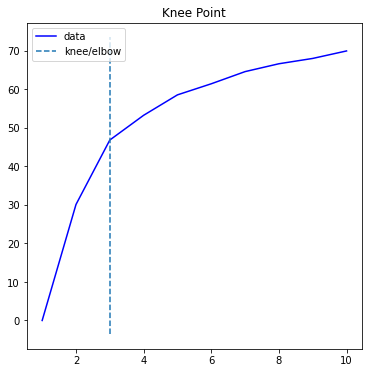

In [6]:
#set range
lego_K_MAX = 10
lego_KK = range(1, lego_K_MAX+1)

#kmeans for values within the range defined above
lego_KM = [kmeans(lego_kmeans,k) for k in lego_KK]

#centroids for each output
lego_centroids = [cent for (cent,var) in lego_KM]

#centroids for each iteration of k
lego_D_k = [cdist(lego_kmeans, cent, 'euclidean') for cent in lego_centroids]
lego_cIdx = [np.argmin(D,axis=1) for D in lego_D_k]
lego_dist = [np.min(D,axis=1) for D in lego_D_k]

lego_tot_withinss = [sum(d**2) for d in lego_dist]
lego_totss = sum(pdist(lego_kmeans)**2)/lego_kmeans.shape[0]
lego_betweenss = lego_totss - lego_tot_withinss  


clr = cm.Spectral(np.linspace(0,1,10)).tolist()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lego_KK, lego_betweenss/lego_totss*100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained (%)')
plt.title('Elbow for KMeans clustering')


lego_k1= KneeLocator(x=lego_KK, y=lego_betweenss/lego_totss*100, curve= 'concave', direction='increasing',
                   S=1)

lego_k1.plot_knee()
lego_elbow_cluster= lego_k1.knee
print(lego_elbow_cluster)

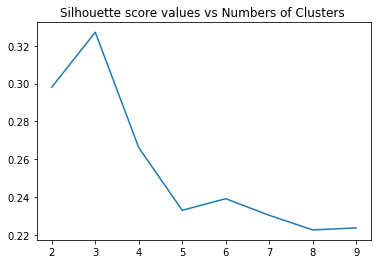

Optimal number of components is: 3


In [7]:
from sklearn.cluster import KMeans

obs = lego_kmeans
lego_silhouette_score_values=list()
lego_NumberOfClusters = range(2,lego_K_MAX)
 
for i in lego_NumberOfClusters:
    classifier = sklearn.cluster._kmeans.KMeans(i,
                                init = 'k-means++', 
                                n_init = 10, 
                                max_iter = 300, 
                                tol = 0.0001, 
                                verbose = 0, 
                                random_state = None, 
                                copy_x = True)
    classifier.fit(obs)
    labels= classifier.predict(obs)
    sklearn.metrics.silhouette_score(obs,
                                     labels,
                                     metric = 'euclidean', 
                                     sample_size = None, 
                                     random_state = None)
    lego_silhouette_score_values.append(sklearn.metrics.silhouette_score(
                                    obs,
                                    labels,
                                    metric = 'euclidean', 
                                    sample_size = None,
                                    random_state = None))
 
plt.plot(lego_NumberOfClusters, lego_silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()     
 
lego_sil_cluster=lego_NumberOfClusters[lego_silhouette_score_values.index(
    max(lego_silhouette_score_values))]


print("Optimal number of components is:", lego_sil_cluster)

In [8]:
#variance for default number of clusters
print(lego_betweenss[2-1]/lego_totss*100)

#variance for optimal number of clusters
print(lego_betweenss[lego_sil_cluster-1]/lego_totss*100)

30.106252911367747
46.84094429689152


In [9]:
#set optimal no. of clusters
lego_optimal_clusters = max(lego_elbow_cluster, lego_sil_cluster)
#initialize k means
lego_kmeans_optimal = KMeans(n_clusters = lego_optimal_clusters)
#fit with inputs
lego_kmeans_optimal = lego_kmeans_optimal.fit(lego_kmeans)
#predict clusters
lego_labels = lego_kmeans_optimal.predict(lego_kmeans)
#cluster centers
lego_C_optimal= lego_kmeans_optimal.cluster_centers_

,list_price,piece_count,num_reviews,review_difficulty,star_rating,country_num,min_age
clusters,,,,,,,
0,273.065852,2746.690867,98.302108,3.789227,4.632904,10.994145,14.149883
1,49.447952,355.335600,10.135600,2.339851,4.492072,5.201275,6.887141
2,56.501127,366.108771,10.157403,2.355840,4.493313,16.008250,6.857686


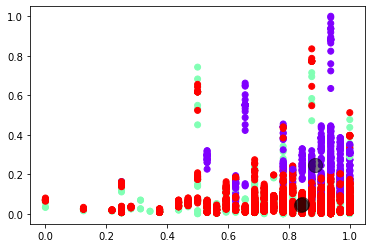

In [10]:
#plot clusters first
plt.scatter(lego_kmeans.iloc[:,4],            
            lego_kmeans.iloc[:,0], 
            c = lego_kmeans_optimal.labels_, 
            cmap = 'rainbow')

#plot centroids over clusters
plt.scatter(lego_C_optimal[:, 4], 
            lego_C_optimal[:, 0], 
            c = 'black', 
            s = 200, 
            alpha = 0.5)


lego_clustered_df= lego_cluster
lego_clustered_df['clusters']= pd.Series(lego_labels)
lego_clustered_df.head()

lego_clusters_groups_means= lego_clustered_df.groupby('clusters').mean()
lego_clusters_groups_means

# Heirarchical Clustering

In [ ]:
#will look at 3 features
lego_clustering= lego_subset[['star_rating', 'list_price', 'country_num']]
lego_clustering.head

scaler= MinMaxScaler()
lego_clustering_scaled= scaler.fit_transform(lego_clustering)
lego_hier= pd.DataFrame(lego_clustering_scaled, columns= lego_clustering.columns)
lego_hier.head

#distance matrix
lego_dist= pdist(lego_hier, 'euclidean')
#linkage matrix
lego_linked= linkage(lego_dist, 'ward')


plt.figure(figsize = (10, 8))  
plt.title("Cluster dendrogram")  
dendo = dendrogram(lego_linked)
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))  
plt.title('Hierarchical clustering dendrogram (pruned)')
dendrogram(lego_linked,
           truncate_mode = 'lastp',   
           p = 15,                    
           show_leaf_counts = False,  
           leaf_rotation = 90,        
           leaf_font_size = 12,       
           show_contracted = True)    
plt.show()

In [ ]:
plt.figure(figsize = (12, 10))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(lego_linked, 
           truncate_mode = 'lastp', 
           p = 10, 
           show_leaf_counts = False,
           leaf_rotation = 90, 
           leaf_font_size = 12, 
           show_contracted = True,
           color_threshold = 2)

plt.axhline(y = 2, c='grey', lw=1, linestyle='dashed')
plt.show()

In [ ]:
lego_clusters = AgglomerativeClustering(n_clusters = 2,
                                         affinity = 'euclidean',
                                         linkage = 'ward')
lego_clusters.fit_predict(lego_hier)
print(lego_clusters.labels_)

In [ ]:
plt.scatter(lego_hier['star_rating'],
            lego_hier['list_price'],
            lego_hier['country_num'],
            alpha = 0.8,
            c = lego_clusters.labels_)
plt.xlabel('Rating')  
plt.ylabel('Price in USD')  
plt.show()

# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [ ]:
lego_subset= lego_subset[['list_price', 'piece_count', 'num_reviews', 'review_difficulty', 'country_num', 'star_rating', 'min_age']]

scaler= StandardScaler()
lego_subset_scaled= scaler.fit_transform(lego_subset)
lego_subset_scaled= pd.DataFrame(lego_subset_scaled, columns= lego_subset.columns)
lego_subset_scaled.head()

In [ ]:
scatter_m = scatter_matrix(lego_subset_scaled, 
                           alpha = 0.8, 
                           figsize = (6, 6), 
                           diagonal = 'kde')
plt.show()

In [ ]:
dbscan = DBSCAN(eps=0.4, min_samples = 3)
clusters = dbscan.fit_predict(lego_subset_scaled)

unique, counts = np.unique(clusters, return_counts=True)
print(np.asarray((unique, counts)).T)

In [ ]:
plt.scatter(lego_subset_scaled['star_rating'],
            lego_subset_scaled['piece_count'],
            alpha = 0.8,
            cmap = 'magma',
            c = clusters)
plt.xlabel('Rating')  
plt.ylabel('Pieces')  
plt.show()

In [ ]:
n_trainingData = 0         
labels = 0                  
n_clusters = 0             


def Get_distanceMean(points,minPts,previous_distanceMean):
  if (minPts < len(points)):
      nbrs = NearestNeighbors(n_neighbors=minPts).fit(points)
      distances, indices = nbrs.kneighbors(points)
      d_mean = distances.mean()
      return d_mean
  else:
      return previous_distanceMean

def kNNdist_plot(points,minPts):
  epsPlot = []
  current_distanceMean = previous_distanceMean = 0
  knee_value = knee_found = 0
  for i in range (0,len(points),5):
      current_distanceMean = Get_distanceMean(points[i:],minPts,previous_distanceMean)
      df = current_distanceMean - previous_distanceMean
      if ((df > 0.02) & (i > 1) & (knee_found == 0)):
          knee_value = current_distanceMean
          knee_found = 1
          n_trainingData = i
      epsPlot.append( [i,current_distanceMean] )
      previous_distanceMean = current_distanceMean
  for i in range(0, len(epsPlot)):
      plt.scatter(epsPlot[i][0],epsPlot[i][1],c='r',s=3,marker='o')
  plt.axhline(y=knee_value, color='g', linestyle='-')
  plt.axvline(x=n_trainingData , color='g', linestyle='-')
  plt.title("kNN distance")
  return plt, n_trainingData, knee_value

In [ ]:
plt, n_trainingData,  best_eps = kNNdist_plot(lego_subset_scaled, 3)
plt.show()
print(best_eps)

In [ ]:
dbscan = DBSCAN(eps=best_eps, min_samples = 3)
optimized_clusters = dbscan.fit_predict(lego_subset_scaled)

unique, counts = np.unique(optimized_clusters, return_counts=True)
print(np.asarray((unique, counts)).T)


lego_subset_scaled['optimized_clusters'] = optimized_clusters
lego_subset_scaled = lego_subset_scaled[lego_subset_scaled.optimized_clusters >-1]
optimized_clusters = lego_subset_scaled['optimized_clusters']
lego_subset_scaled

In [ ]:
plt.scatter(lego_subset_scaled['star_rating'],
            lego_subset_scaled['piece_count'],
            alpha = 0.8,
            cmap = 'magma',
            c = optimized_clusters)
plt.xlabel('Rating')  
plt.ylabel('Pieces')  
plt.show()